In [17]:
import numpy as np
import os
import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def eval_from_scrach(gt_dir, det_dir):

    all_gt, all_det = [], []
    all_f = sorted(os.listdir(det_dir))
    for i, f in enumerate(all_f):
        gt_f = np.loadtxt(os.path.join(gt_dir, f), dtype=str).reshape(-1, 15)
        det_f = np.loadtxt(os.path.join(det_dir, f), dtype=str).reshape(-1, 16)

        gt = {}
        det = {}
        
        '''name'''
        valid = gt_f[:, 0] == 'Car'
        gt['name'] = gt_f[:, 0][valid]
        det['name'] = det_f[:, 0]
        
        '''bbox'''
        gt['bbox'] = gt_f[:, 4:8].astype(np.float32)[valid]
        det['bbox'] = det_f[:, 4:8].astype(np.float32)

        '''alpha'''
        gt['alpha'] = gt_f[:, 3].astype(np.float32)[valid]
        det['alpha'] = det_f[:, 3].astype(np.float32)

        '''occluded'''
        gt['occluded'] = gt_f[:, 2].astype(np.float32)[valid]
        det['occluded'] = det_f[:, 2].astype(np.float32)

        '''truncated'''
        gt['truncated'] = gt_f[:, 1].astype(np.float32)[valid]
        det['truncated'] = det_f[:, 1].astype(np.float32)

        '''location'''
        gt['location'] = gt_f[:, 11:14].astype(np.float32)[valid]
        det['location'] = det_f[:, 11:14].astype(np.float32)

        '''dimensions, convert hwl to lhw'''
        gt['dimensions'] = gt_f[:, [10, 8, 9]].astype(np.float32)[valid]
        det['dimensions'] = det_f[:, [10, 8, 9]].astype(np.float32)

        '''rotation_y'''
        gt['rotation_y'] = gt_f[:, 14].astype(np.float32)[valid]
        det['rotation_y'] = det_f[:, 14].astype(np.float32)

        '''score'''
        det['score'] = det_f[:, 15].astype(np.float32)

        all_gt.append(gt)
        all_det.append(det)
        
    # all_gt: list(3769), each label is a dict
    # {'bbox': array([[599.41, 156.4 , 629.75, 189.25],
    #        [387.63, 181.54, 423.81, 203.12],
    #        [559.62, 175.83, 575.4 , 183.15]], dtype=float32),
    # 'alpha': array([-1.57, -1.57, -1.57], dtype=float32),
    # 'occluded': array([0., 0., 0.], dtype=float32),
    # ...}
    return all_det, all_gt

In [4]:
eval_dir = "/home/a/DID-M3D/tmp_test/flip-crop/checkpoint_epoch_150"

In [10]:
all_det, all_gt =  eval_from_scrach(
        "/mnt/e/DataSet/kitti/training/label_2",
        os.path.join(eval_dir, "data")
    )

In [11]:
import pickle
with open(os.path.join(eval_dir, "all_det.pkl"), "wb") as f:
    pickle.dump(all_det, f)
with open(os.path.join(eval_dir, "all_gt.pkl"), "wb") as f:
    pickle.dump(all_gt, f)

In [204]:
all_det[1], all_gt[1]

({'name': array(['Car'], dtype='<U6'),
  'bbox': array([[655.41, 191.43, 701.15, 221.87]], dtype=float32),
  'alpha': array([-1.7], dtype=float32),
  'occluded': array([0.], dtype=float32),
  'truncated': array([0.], dtype=float32),
  'location': array([[ 3.73,  2.56, 39.51]], dtype=float32),
  'dimensions': array([[4.71, 1.53, 1.76]], dtype=float32),
  'rotation_y': array([-1.61], dtype=float32),
  'score': array([0.26], dtype=float32)},
 {'name': array(['Car'], dtype='<U6'),
  'bbox': array([[657.39, 190.13, 700.07, 223.39]], dtype=float32),
  'alpha': array([-1.67], dtype=float32),
  'occluded': array([0.], dtype=float32),
  'truncated': array([0.], dtype=float32),
  'location': array([[ 3.18,  2.27, 34.38]], dtype=float32),
  'dimensions': array([[4.36, 1.41, 1.58]], dtype=float32),
  'rotation_y': array([-1.58], dtype=float32)})

In [162]:
from tools.eval import calculate_iou_partly

overlaps, parted_overlaps, total_dt_num, total_gt_num = calculate_iou_partly(
    all_det,
    all_gt,
    2,
    50,
    z_axis=1,
    z_center=1)

 # r: det, c: gt

In [44]:
overlaps[0].shape

(0, 1)

In [65]:
np.argmax(overlaps[5][1])

5

In [166]:
precise = {key:0 for key in np.linspace(0, 95, 20, dtype=np.int32)}
number = {key:0 for key in np.linspace(0, 95, 20)}

for i in range(len(overlaps)):
    overlap = overlaps[i]
    det = all_det[i]
    gt = all_gt[i]
    
    if overlap.size == 0:
        continue
    
    for j in range(len(det['score'])):
        s = int((det['score'][j] * 100) // 5 * 5)
        valid = np.max(overlap, axis=1) >= 0.5
        if valid[j]:
                precise[s] += 1
        number[s] += 1

precise, number

({0: 2,
  5: 13,
  10: 40,
  15: 83,
  20: 151,
  25: 256,
  30: 397,
  35: 284,
  40: 559,
  45: 404,
  50: 557,
  55: 660,
  60: 971,
  65: 954,
  70: 728,
  75: 198,
  80: 0,
  85: 0,
  90: 0,
  95: 0},
 {0.0: 194,
  5.0: 369,
  10.0: 562,
  15.0: 734,
  20.0: 883,
  25.0: 971,
  30.0: 1230,
  35.0: 788,
  40.0: 1271,
  45.0: 861,
  50.0: 1032,
  55.0: 982,
  60.0: 1270,
  65.0: 1116,
  70.0: 778,
  75.0: 200,
  80.0: 0,
  85.0: 0,
  90.0: 0,
  95.0: 0})

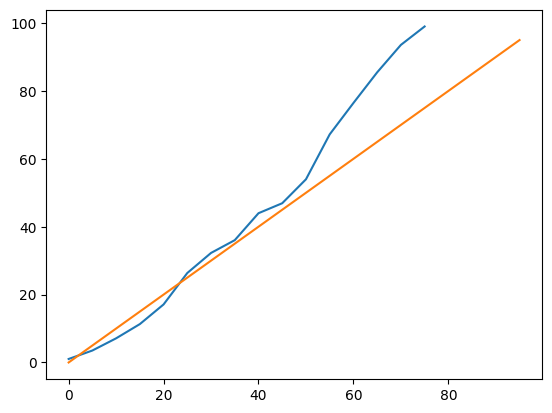

In [167]:
from matplotlib import pyplot as plt

y = np.array(list(precise.values())) / np.array(list(number.values())) * 100
x = np.array(list(precise.keys()))
x_ = x.copy()
plt.plot(x, y)
plt.plot(x, x_)
plt.show()

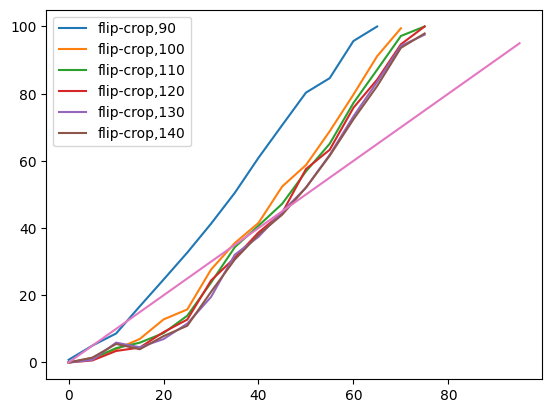

In [22]:
use_depth = False
all_y = {}
from itertools import product

for e,d in product([90,100,110,120,130,140], ['flip-crop']):
    eval_dir = f"/home/a/DID-M3D/tmp_test/{d}/checkpoint_epoch_{e}"
    import pickle
    with open(os.path.join(eval_dir, "all_det.pkl"), "rb") as f:
        all_det = pickle.load(f)
    with open(os.path.join(eval_dir, "all_gt.pkl"), "rb") as f:
        all_gt = pickle.load(f)
    from tools.eval import calculate_iou_partly

    overlaps, parted_overlaps, total_dt_num, total_gt_num = calculate_iou_partly(
    all_det,
    all_gt,
    2,
    50,
    z_axis=1,
    z_center=1)
    
    precise = {key:0 for key in np.linspace(0, 95, 20, dtype=np.int32)}
    number = {key:0 for key in np.linspace(0, 95, 20)}
    
    for i in range(len(overlaps)):
        overlap = overlaps[i]
        det = all_det[i]
        gt = all_gt[i]
        
        if overlap.size == 0:
            continue
        
        for j in range(len(det['score'])):
            s = int((det['score'][j] * 100) // 5 * 5)
            if use_depth:
                k = np.argmax(overlap[j])
                z_gt = gt['location'][k][2]
                z_det = det['location'][j][2]
                if abs(z_gt - z_det) < 0.4:
                    precise[s] += 1
            else:
                valid = np.max(overlap, axis=1) >= 0.5
                if valid[j]:
                    precise[s] += 1
            number[s] += 1
    
    from matplotlib import pyplot as plt

    y = np.array(list(precise.values())) / np.array(list(number.values())) * 100
    x = np.array(list(precise.keys()))
    plt.plot(x,y,label=f"{d},{e}")
    all_y[f'{d} {e}'] = {
        'x': x,
        'y': y,
        'precise': precise,
        'number': number
    }
plt.plot(x,x)
plt.legend()
plt.show()

In [23]:


for k, v in all_y.items():
    all_num = 0
    for num in v['number'].values():
        all_num += num
    mae = 0
    for i in range(len(v['x'])):
        if np.isnan(v['y'][i]):
            continue
        mae += v['number'][5 * i] * abs(v['x'][i] - v['y'][i])
    mae /= all_num
    print(f'{k},{mae}')

flip-crop 90,12.966629588431593
flip-crop 100,9.329523382638575
flip-crop 110,9.312148957451717
flip-crop 120,9.134637426453734
flip-crop 130,9.15595412208452
flip-crop 140,8.940274227283291


In [16]:
all_y

{'aug-flip-drx-1': {'x': array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
         85, 90, 95], dtype=int32),
  'y': array([ 1.03092784,  3.52303523,  7.11743772, 11.30790191, 17.10079275,
         26.36457261, 32.27642276, 36.04060914, 43.98111723, 46.92218351,
         53.97286822, 67.20977597, 76.45669291, 85.48387097, 93.57326478,
         99.        ,         nan,         nan,         nan,         nan]),
  'precise': {0: 2,
   5: 13,
   10: 40,
   15: 83,
   20: 151,
   25: 256,
   30: 397,
   35: 284,
   40: 559,
   45: 404,
   50: 557,
   55: 660,
   60: 971,
   65: 954,
   70: 728,
   75: 198,
   80: 0,
   85: 0,
   90: 0,
   95: 0},
  'number': {0.0: 194,
   5.0: 369,
   10.0: 562,
   15.0: 734,
   20.0: 883,
   25.0: 971,
   30.0: 1230,
   35.0: 788,
   40.0: 1271,
   45.0: 861,
   50.0: 1032,
   55.0: 982,
   60.0: 1270,
   65.0: 1116,
   70.0: 778,
   75.0: 200,
   80.0: 0,
   85.0: 0,
   90.0: 0,
   95.0: 0}},
 'no-aug-loss': {'x': array([ 0,  5, 